In [1]:
# !pip install torchtext
# !pip install torch
import torch
from torch import nn
import time
import torchtext
import numpy as np
import pandas as pd
import torch.optim as optim
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict, Counter
import os
import sys
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import io
from collections import Counter
from typing import List, Tuple

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

C:\Users\Marco Yu\anaconda3\envs\nlp_20220614\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def init_embeddings(vocab_size, embed_dim, unif):
    return np.random.uniform(-unif, unif, (vocab_size, embed_dim))


class EmbeddingsReader:

    @staticmethod
    def from_text(filename, vocab, unif=0.25):

        with io.open(filename, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                line = line.rstrip("\n ")
                values = line.split(" ")

                if i == 0:
                    # fastText style
                    if len(values) == 2:
                        weight = init_embeddings(len(vocab), values[1], unif)
                        continue
                    # glove style
                    else:
                        weight = init_embeddings(len(vocab), len(values[1:]), unif)
                word = values[0]
                if word in vocab:
                    vec = np.asarray(values[1:], dtype=np.float32)
                    weight[vocab[word]] = vec
        if '[PAD]' in vocab:
            weight[vocab['[PAD]']] = 0.0

        embeddings = nn.Embedding(weight.shape[0], weight.shape[1])
        embeddings.weight = nn.Parameter(torch.from_numpy(weight).float())
        return embeddings, weight.shape[1]

    @staticmethod
    def from_binary(filename, vocab, unif=0.25):
        def read_word(f):

            s = bytearray()
            ch = f.read(1)

            while ch != b' ':
                s.extend(ch)
                ch = f.read(1)
            s = s.decode('utf-8')
            # Only strip out normal space and \n not other spaces which are words.
            return s.strip(' \n')

        vocab_size = len(vocab)
        with io.open(filename, "rb") as f:
            header = f.readline()
            file_vocab_size, embed_dim = map(int, header.split())
            weight = init_embeddings(len(vocab), embed_dim, unif)
            if '[PAD]' in vocab:
                weight[vocab['[PAD]']] = 0.0
            width = 4 * embed_dim
            for i in range(file_vocab_size):
                word = read_word(f)
                raw = f.read(width)
                if word in vocab:
                    vec = np.fromstring(raw, dtype=np.float32)
                    weight[vocab[word]] = vec
        embeddings = nn.Embedding(weight.shape[0], weight.shape[1])
        embeddings.weight = nn.Parameter(torch.from_numpy(weight).float())
        return embeddings, embed_dim


In [3]:
class Reader:

    def __init__(self, files, lowercase=True, min_freq=0, vectorizer=None):
        self.vectorizer = vectorizer if vectorizer else self._vectorizer
        x = Counter()
        y = Counter()
        for file_name in files:
            if file_name is None:
                continue
            print(file_name)
            df=pd.read_csv(file_name,delimiter='\t',names=['Word','POS','NP','NER'],skiprows=[0])
            df=df.dropna()
            x.update(df.Word.to_list())
            y.update(df.NER.to_list())

        # build vocab
        x = dict(filter(lambda cnt: cnt[1] >= min_freq, x.items()))
        alpha = list(x.keys())
        # alpha.sort()
        self.vocab = {w: i+1 for i, w in enumerate(alpha)}
        self.vocab['[PAD]'] = 0

        self.labels = list(y.keys())
        # self.labels.sort()



        # self.lowercase = lowercase
        # self.tokenizer = tokenizer
        # build_vocab = vectorizer is None
        # self.vectorizer = vectorizer if vectorizer else self._vectorizer
        # x = Counter()
        # y = Counter()
        # for file_name in files:
        #     if file_name is None:
        #         continue
        #     with open(file_name, encoding='utf-8', mode='r') as f:
        #         for line in f:
        #             words = line.split()
        #             y.update(words[0])
        #
        #             if build_vocab:
        #                 words = self.tokenizer(' '.join(words[1:]))
        #                 words = words if not self.lowercase else [w.lower() for w in words]
        #                 x.update(words)
        # self.labels = list(y.keys())
        #
        # if build_vocab:
        #     x = dict(filter(lambda cnt: cnt[1] >= min_freq, x.items()))
        #     alpha = list(x.keys())
        #     alpha.sort()
        #     self.vocab = {w: i+1 for i, w in enumerate(alpha)}
        #     self.vocab['[PAD]'] = 0
        #
        # self.labels.sort()

    def extract_sent(self, df):
        sentences=[]
        labels=[]
        label=[]
        sentence=[]
        for word,tag in zip(df.Word,df.NER):
            label.append(tag)
            sentence.append(word)
            if word =='.':
                labels.append(label)
                sentences.append(sentence)
                sentence=[]
                label=[]
        return sentences, labels


    def _vectorizer(self, words: List[str]) -> List[int]:
        return [self.vocab.get(w, 0) for w in words]

    def load(self, filename: str) -> TensorDataset:
        label2index = {l: i+1 for i, l in enumerate(self.labels)}
        label2index['[PAD]'] = 0
        xs = []
        lengths = []
        ys = []
        df=pd.read_csv(filename,delimiter='\t',names=['Word','POS','NP','NER'],skiprows=[0])
        df=df.dropna()
        sentences, label_sets=self.extract_sent(df)

        for sentence, label_set in zip(sentences,label_sets):
            ys.append(torch.tensor(list(label2index[label] for label in label_set), dtype=torch.long))
            words=sentence # just remind that sentence are already list of words
            vec = self.vectorizer(words)
            lengths.append(len(vec))
            xs.append(torch.tensor(vec, dtype=torch.long))
        x_tensor = torch.nn.utils.rnn.pad_sequence(xs, batch_first=True)
        lengths_tensor = torch.tensor(lengths, dtype=torch.long)
        y_tensor= torch.nn.utils.rnn.pad_sequence(ys, batch_first=True)
        # y_tensor q= torch.tensor(ys, dtype=torch.long)
        return TensorDataset(x_tensor, lengths_tensor, y_tensor)
BASE = 'data'
TRAIN=os.path.join(BASE, 'train.conll')
VALID=os.path.join(BASE,'dev.conll')
TEST=os.path.join(BASE,'test.conll')
r=Reader((TRAIN,VALID,TEST))
train = r.load(TRAIN)
valid=r.load(VALID)
test=r.load(TEST)

data\train.conll
data\dev.conll
data\test.conll


In [4]:
PRETRAINED_EMBEDDINGS_FILE='word_embedding/glove.6B.50d/glove.6B.50d.txt'
embeddings, embed_dim = EmbeddingsReader.from_text(PRETRAINED_EMBEDDINGS_FILE, r.vocab)

In [5]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, embeddings, num_classes, embed_dim, rnn_units,tag_to_ix,batch_size, rnn_layers=1, dropout=0.1, hidden_units=[]):
        super().__init__()
        # self.embedding_dim = embedding_dim
        self.hidden_dim = rnn_units
        # self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix # dictionary of tags
        self.tagset_size = len(tag_to_ix)
        self.batch_size=batch_size

        self.embeddings=embeddings
        self.lstm = nn.LSTM(embed_dim, rnn_units // 2,
                        num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(rnn_units, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
        torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, self.batch_size, self.hidden_dim // 2),
                torch.randn(2, self.batch_size, self.hidden_dim // 2))


        # self.embeddings=embeddings
        # self.dropout=nn.Dropout(dropout)
        # self.rnn=nn.LSTM(embed_dim,rnn_units,
        #                  num_layers=rnn_layers,
        #                  dropout=dropout,
        #                  bidirectional=False,
        #                  batch_first=False)
        #
        # nn.init.orthogonal_(self.rnn.weight_hh_l0)
        # nn.init.orthogonal_(self.rnn.weight_ih_l0)
        #
        # # build hidden layers
        # sequence=[]
        # input_units=rnn_units
        # output_units=rnn_units
        # for h in hidden_units:
        #     sequence.append(nn.Linear(input_units,h))
        #     input_units=h
        #     output_units=h
        #
        # sequence.append(nn.Linear(output_units,num_classes)) # add final classifier layer
        # self.outputs=nn.Sequential(*sequence) # create sequential model for every hidden layer
    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, inputs):
        one_hots, lengths = inputs
        self.hidden = self.init_hidden()
        # embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        embeds=self.embeddings(one_hots)
        embeds=embeds.transpose(0,1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeds, lengths.tolist())
        lstm_out, hidden = self.lstm(packed, self.hidden)
        # print(lstm_out.shape())
        lstm_outs, lstm_outs_lengths=torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
        # lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_outs)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags]) # Add START_TAG ahead of the origin tags
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, inputs, tags):
        feats = self._get_lstm_features(inputs)

        feats=feats.view(-1,self.tagset_size)

        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, inputs):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(inputs)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq


In [7]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"

In [8]:
def process_bar(num, total):
    rate = float(num) / total
    ratenum = int(100 * rate)
    r = '\rModel training:[{}{}]{}%'.format('*' * ratenum, ' ' * (100 - ratenum), ratenum)
    sys.stdout.write(r)
    sys.stdout.flush()

class Trainer:
    def __init__(self,optimizer:torch.optim.Optimizer):
        self.optimizer=optimizer
        pass

    def run(self,model, train, loss, batch_size,labels,optimizer=None):
        model.train()
        self.optimizer= optimizer if optimizer else self.optimizer
        cm=ConfusionMatrix(labels)

        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
        log_interval = int(len(train_loader) * 0.01)
        for batch_idx, batch in enumerate(train_loader):

            loss_value, y_pred, y_actual = self.update(model, loss, batch,self.optimizer)
            # _, best = y_pred.max(1)
            yt = y_actual.cpu().int().numpy()
            yp = y_pred.cpu().int().numpy()
            cm.add_batch(yt,yp)
            if batch_idx % log_interval == 0:  # 根据设置的显式间隔输出训练日志
                process_bar(batch_idx, len(train_loader))

        print(cm.get_all_metrics())
        return cm

    def update(self,model, loss, batch, optimizer):
            optimizer.zero_grad()
            x, lengths, y = batch
            # print(batch)
            lengths, perm_idx = lengths.sort(0, descending=True)
            x_sorted = x[perm_idx]
            y_sorted = y[perm_idx]
            # print(x_sorted,lengths,y_sorted)
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            y_sorted = y_sorted.to(device)
            inputs = (x_sorted.to(device), lengths)
            # print(inputs)
            y_pred = model(inputs)

            mask = (y_sorted != 0)
            valid = (mask.sum(dim=1))
            y_sorted=y_sorted[mask].split(valid.tolist())[0]

            y_sorted=np.array(y_sorted).tolist()
            y_sorted=torch.tensor(y_sorted, dtype=torch.long)
            y_pred=(torch.tensor(y_pred[1], dtype=torch.long))
            loss_value=model.neg_log_likelihood(inputs, y_sorted)
            # loss_value = loss(torch.tensor(y_pred[1],dtype= torch.long), torch.tensor(y_sorted,dtype= torch.long))
            loss_value.backward()
            optimizer.step()
            return loss_value.item(), y_pred, y_sorted

In [9]:
class Evaluator:
    def __init__(self):
        pass

    def run(self,model, dataset, labels, batch_size=1):
        model.train()

        cm=ConfusionMatrix(labels)

        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        log_interval = int(len(train_loader) * 0.01)
        for batch_idx, batch in enumerate(train_loader):

            y_pred, y_actual = self.inference(model, batch)
            # _, best = y_pred.max(1)
            yt = y_actual.cpu().int().numpy()
            yp = y_pred.cpu().int().numpy()
            cm.add_batch(yt,yp)
            # if batch_idx % log_interval == 0:  # 根据设置的显式间隔输出训练日志
            #     process_bar(batch_idx, len(train_loader))

        print(cm.get_all_metrics())
        return cm

    def inference(self, model, batch):
        with torch.no_grad():
            x, lengths, y = batch
            lengths, perm_idx = lengths.sort(0, descending=True)
            x_sorted = x[perm_idx]
            y_sorted = y[perm_idx]
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            y_sorted = y_sorted.to(device)
            inputs = (x_sorted.to(device), lengths)
            y_pred = model(inputs)

            mask = (y_sorted != 0)
            valid = (mask.sum(dim=1))
            y_sorted=y_sorted[mask].split(valid.tolist())[0]

            y_sorted=np.array(y_sorted).tolist()
            y_sorted=torch.tensor(y_sorted, dtype=torch.long)
            y_pred=(torch.tensor(y_pred[1], dtype=torch.long))

            return y_pred, y_sorted

In [10]:
def fit(model, labels, optimizer, loss, epochs, batch_size, train, valid, test):

    trainer = Trainer(optimizer)
    evaluator = Evaluator()
    best_acc = 0.0

    for epoch in range(epochs):
        print('EPOCH {}'.format(epoch + 1))
        print('=================================')
        print('Training Results')
        cm = trainer.run(model, labels=labels, train=train, loss=loss, batch_size=batch_size)
        print('Validation Results')
        cm = evaluator.run(model,valid,labels=labels)
        print(cm.get_all_metrics())
        if cm.get_acc() > best_acc:
            print('New best model {:.2f}'.format(cm.get_acc()))
            best_acc = cm.get_acc()
            torch.save(model.state_dict(), './checkpoint.pth')
    if test:
        model.load_state_dict(torch.load('./checkpoint.pth'))
        cm = evaluator.run(model,valid,labels=labels)
        print('Final result')
        print(cm.get_all_metrics())
    return cm.get_acc()

In [20]:
label2index = {l: i+1 for i, l in enumerate(r.labels)}
label2index['[PAD]'] = 0
label2index[START_TAG] = len(r.labels)+1
label2index[STOP_TAG] = len(r.labels)+2



model  = LSTMClassifier(embeddings, len(r.labels), embed_dim, 100,tag_to_ix=label2index,batch_size= 1, hidden_units=[100])

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {num_params} parameters")

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss = torch.nn.CrossEntropyLoss()
loss = loss.to(device)

learnable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(learnable_params,lr=0.001)
# train_mini_set = train_dataset
train_mini_set = train[:900]
train_mini_set = TensorDataset(train_mini_set[0], train_mini_set[1],train_mini_set[2])
fit(model, label2index.keys(), optimizer, loss, 20, 1, train_mini_set, valid, test)



Model has 1556556 parameters
EPOCH 1
Training Results
Model training:[                                                                                                    ]0%

C:\Users\Marco Yu\AppData\Local\Temp\ipykernel_22924\3123264233.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._cm = np.zeros((nc, nc), dtype=np.int)


Model training:[*************************************************************************************************** ]99%{'acc': 0.8220400186923829, 'mean_precision': 0.23693003912972874, 'mean_recall': 0.16282344034556204, 'macro_f1': 0.17860746385353918, 'weighted_precision': 0.7712630012247131, 'weighted_recall': 0.8220400186923829, 'weighted_f1': 0.786474760018041}
Validation Results
{'acc': 0.8660948437345953, 'mean_precision': 0.3081198007606099, 'mean_recall': 0.22011041092229652, 'macro_f1': 0.23577878971062693, 'weighted_precision': 0.8210817840130403, 'weighted_recall': 0.8660948437345953, 'weighted_f1': 0.835268242121525}
{'acc': 0.8660948437345953, 'mean_precision': 0.3081198007606099, 'mean_recall': 0.22011041092229652, 'macro_f1': 0.23577878971062693, 'weighted_precision': 0.8210817840130403, 'weighted_recall': 0.8660948437345953, 'weighted_f1': 0.835268242121525}
New best model 0.87
EPOCH 2
Training Results
Model training:[*************************************************

0.9162772355318939

In [ ]:
# train_mini_set = train_dataset
train_mini_set = train[:300]
train_mini_set = TensorDataset(train_mini_set[0], train_mini_set[1],train_mini_set[2])

In [ ]:
train_loader = DataLoader(test, batch_size=1, shuffle=True)
log_interval = int(len(train_loader) * 0.01)
for batch_idx, batch in enumerate(train_loader):

    loss_value, y_pred, y_actual = update(model, loss, batch,optimizer)
    # _, best = y_pred.max(1)
    yt = y_actual.cpu().int().numpy()
    yp = y_pred.cpu().int().numpy()
    if batch_idx==0:
        print(loss_value, y_pred, y_actual)
        break

In [ ]:
x, lengths, y = train[0]
print(x,lengths,y)

In [13]:

class ConfusionMatrix:
    """Confusion matrix with metrics

    This class accumulates classification output, and tracks it in a confusion matrix.
    Metrics are available that use the confusion matrix
    """
    def __init__(self, labels):
        """Constructor with input labels

        :param labels: Either a dictionary (`k=int,v=str`) or an array of labels
        """
        if type(labels) is dict:
            self.labels = []
            for i in range(len(labels)):
                self.labels.append(labels[i])
        else:
            self.labels = labels
        nc = len(self.labels)
        self._cm = np.zeros((nc, nc), dtype=np.int)

    def add(self, truth, guess):
        """Add a single value to the confusion matrix based off `truth` and `guess`

        :param truth: The real `y` value (or ground truth label)
        :param guess: The guess for `y` value (or assertion)
        """

        self._cm[truth, guess] += 1

    def __str__(self):
        values = []
        width = max(8, max(len(x) for x in self.labels) + 1)
        for i, label in enumerate([''] + self.labels):
            values += ["{:>{width}}".format(label, width=width+1)]
        values += ['\n']
        for i, label in enumerate(self.labels):
            values += ["{:>{width}}".format(label, width=width+1)]
            for j in range(len(self.labels)):
                values += ["{:{width}d}".format(self._cm[i, j], width=width + 1)]
            values += ['\n']
        values += ['\n']
        return ''.join(values)

    def save(self, outfile):
        ordered_fieldnames = OrderedDict([("labels", None)] + [(l, None) for l in self.labels])
        with open(outfile, 'w') as f:
            dw = csv.DictWriter(f, delimiter=',', fieldnames=ordered_fieldnames)
            dw.writeheader()
            for index, row in enumerate(self._cm):
                row_dict = {l: row[i] for i, l in enumerate(self.labels)}
                row_dict.update({"labels": self.labels[index]})
                dw.writerow(row_dict)

    def reset(self):
        """Reset the matrix
        """
        self._cm *= 0

    def get_correct(self):
        """Get the diagonals of the confusion matrix

        :return: (``int``) Number of correct classifications
        """
        return self._cm.diagonal().sum()

    def get_total(self):
        """Get total classifications

        :return: (``int``) total classifications
        """
        return self._cm.sum()

    def get_acc(self):
        """Get the accuracy

        :return: (``float``) accuracy
        """
        return float(self.get_correct())/self.get_total()

    def get_recall(self):
        """Get the recall

        :return: (``float``) recall
        """
        total = np.sum(self._cm, axis=1)
        total = (total == 0) + total
        return np.diag(self._cm) / total.astype(float)

    def get_support(self):
        return np.sum(self._cm, axis=1)

    def get_precision(self):
        """Get the precision
        :return: (``float``) precision
        """

        total = np.sum(self._cm, axis=0)
        total = (total == 0) + total
        return np.diag(self._cm) / total.astype(float)

    def get_mean_precision(self):
        """Get the mean precision across labels

        :return: (``float``) mean precision
        """
        return np.mean(self.get_precision())

    def get_weighted_precision(self):
        return np.sum(self.get_precision() * self.get_support())/float(self.get_total())

    def get_mean_recall(self):
        """Get the mean recall across labels

        :return: (``float``) mean recall
        """
        return np.mean(self.get_recall())

    def get_weighted_recall(self):
        return np.sum(self.get_recall() * self.get_support())/float(self.get_total())

    def get_weighted_f(self, beta=1):
        return np.sum(self.get_class_f(beta) * self.get_support())/float(self.get_total())

    def get_macro_f(self, beta=1):
        """Get the macro F_b, with adjustable beta (defaulting to F1)

        :param beta: (``float``) defaults to 1 (F1)
        :return: (``float``) macro F_b
        """
        if beta < 0:
            raise Exception('Beta must be greater than 0')
        return np.mean(self.get_class_f(beta))

    def get_class_f(self, beta=1):
        p = self.get_precision()
        r = self.get_recall()

        b = beta*beta
        d = (b * p + r)
        d = (d == 0) + d

        return (b + 1) * p * r / d

    def get_f(self, beta=1):
        """Get 2 class F_b, with adjustable beta (defaulting to F1)

        :param beta: (``float``) defaults to 1 (F1)
        :return: (``float``) 2-class F_b
        """
        p = self.get_precision()[1]
        r = self.get_recall()[1]
        if beta < 0:
            raise Exception('Beta must be greater than 0')
        d = (beta*beta * p + r)
        if d == 0:
            return 0
        return (beta*beta + 1) * p * r / d

    def get_all_metrics(self):
        """Make a map of metrics suitable for reporting, keyed by metric name

        :return: (``dict``) Map of metrics keyed by metric names
        """
        metrics = {'acc': self.get_acc()}
        # If 2 class, assume second class is positive AKA 1
        if len(self.labels) == 2:
            metrics['precision'] = self.get_precision()[1]
            metrics['recall'] = self.get_recall()[1]
            metrics['f1'] = self.get_f(1)
        else:
            metrics['mean_precision'] = self.get_mean_precision()
            metrics['mean_recall'] = self.get_mean_recall()
            metrics['macro_f1'] = self.get_macro_f(1)
            metrics['weighted_precision'] = self.get_weighted_precision()
            metrics['weighted_recall'] = self.get_weighted_recall()
            metrics['weighted_f1'] = self.get_weighted_f(1)
        return metrics

    def add_batch(self, truth, guess):
        """Add a batch of data to the confusion matrix

        :param truth: The truth tensor
        :param guess: The guess tensor
        :return:
        """
        for truth_i, guess_i in zip(truth, guess):
            self.add(truth_i, guess_i)



In [ ]:
cm.get_all_metrics()

In [ ]:

class Trainer:
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer

    def run(self, model, labels, train, loss, batch_size):
        model.train()
        train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

        cm = ConfusionMatrix(labels)

        for batch in train_loader:
            loss_value, y_pred, y_actual = self.update(model, loss, batch)
            _, best = y_pred.max(1)
            yt = y_actual.cpu().int().numpy()
            yp = best.cpu().int().numpy()
            cm.add_batch(yt, yp)

        print(cm.get_all_metrics())
        return cm

    def update(self, model, loss, batch):
        self.optimizer.zero_grad()
        x, lengths, y = batch
        lengths, perm_idx = lengths.sort(0, descending=True)
        x_sorted = x[perm_idx]
        y_sorted = y[perm_idx]
        y_sorted = y_sorted.to('cuda:0')
        inputs = (x_sorted.to('cuda:0'), lengths)
        y_pred = model(inputs)
        loss_value = loss(y_pred, y_sorted)
        loss_value.backward()
        self.optimizer.step()
        return loss_value.item(), y_pred, y_sorted

In [ ]:
def fit(model, labels, optimizer, loss, epochs, batch_size, train, valid, test):

    trainer = Trainer(optimizer)
    # evaluator = Evaluator()
    best_acc = 0.0

    for epoch in range(epochs):
        print('EPOCH {}'.format(epoch + 1))
        print('=================================')
        print('Training Results')
        cm = trainer.run(model, labels, train, loss, batch_size)
    #     print('Validation Results')
    #     cm = evaluator.run(model, labels, valid)
    #     print(cm.get_all_metrics())
    #     if cm.get_acc() > best_acc:
    #         print('New best model {:.2f}'.format(cm.get_acc()))
    #         best_acc = cm.get_acc()
    #         torch.save(model.state_dict(), './checkpoint.pth')
    # if test:
    #     model.load_state_dict(torch.load('./checkpoint.pth'))
    #     cm = evaluator.run(model, labels, test)
    #     print('Final result')
    #     print(cm.get_all_metrics())
    return cm.get_acc()

In [ ]:
model  = LSTMClassifier(embeddings, len(r.labels), embed_dim, 100, hidden_units=[100])

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {num_params} parameters")

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss = torch.nn.CrossEntropyLoss()
loss = loss.to(device)

learnable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(learnable_params,lr=1.0)

fit(model, r.labels, optimizer, loss, 5, 50, train, valid, test)

In [ ]:
data = torch.tensor([[1,2,3,0,0],
                     [4,5,0,0,0],
                     [6,7,8,9,0]])
mask = (data != 0)
print(mask)
valid = (mask.sum(dim=1))
print(valid)
data[mask].split(valid.tolist())

In [49]:
df=pd.read_csv(VALID,delimiter='\t',names=['Word','POS','NP','NER'],skiprows=[0])
df=df.dropna()
tags=set(df.NER.to_list())
num_tag= {}
for tag in tags:
    num=df.NER.loc[df.NER==tag].count()
    num_tag[tag]=num
print(list(num_tag.values()))

[922, 42120, 1837, 346, 257, 1303, 751, 1341, 1842]


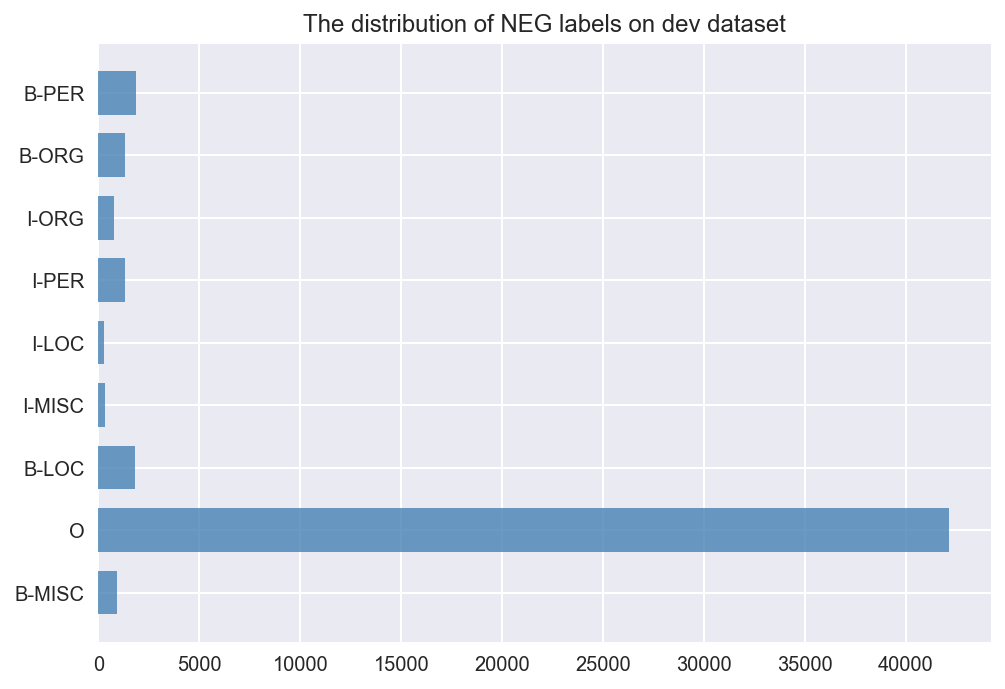

In [50]:
plt.barh(range(len(tags)), list(num_tag.values()), height=0.7, color='steelblue',alpha=0.8)
plt.yticks(range(len(tags)), list(num_tag.keys()))
plt.title("The distribution of NEG labels on dev dataset")
plt.show()